# **The Problem: Automatic Apparent Age Estimation**

In [14]:
import tensorflow as tf

print(tf.__version__)
# decompressing the data
from zipfile import ZipFile
import cv2
import random
from matplotlib import pyplot as plt
import numpy as np
from tensorflow_model_remediation import min_diff
import tensorflow_addons as tfa
import pickle


2.8.2


In [ ]:
!pip install --upgrade tensorflow-model-remediation
!pip install tensorflow-addons
!pip install plotly


In [15]:
# Experiment name and path
EXPERIMENT_NAME = "resnet"
# Model type. ResNet or EfficientNet
MODEL_TYPE = "resnet"

# 📜 Define functions

In [16]:
def mae_evaluation(model_path, X_valid, Y_valid, pred_show_num=5, verbose=True, return_prediction=False):

    saved_model = tf.keras.models.load_model(model_path, compile=False)

    # predict on the test data
    predictions = saved_model.predict(X_valid, batch_size=32, verbose=1)

    predictions_final = predictions * 100

    # evaluating on Validation data
    error = []
    for i in range(0, len(Y_valid)):
        error.append(abs(np.subtract(predictions_final[i][0], Y_valid[i] * 100)))

    if verbose:
        print("MAE (Validation) = %.8f" % (np.mean(error)))

        # printing some predictions
        for i in range(0, pred_show_num):
            print(
                "predicted age = %.3f - Ground truth = %.3f"
                % (predictions_final[i], Y_valid[i] * 100)
            )
    if return_prediction:
        return np.mean(error), predictions_final
    
    return np.mean(error)



def gen_valid_pred(model_path, X_valid):
    saved_model = tf.keras.models.load_model(model_path, compile=False)

    # --------------------------
    ENABLE_EVALUATION_WEIGHTED = True
    # --------------------------

    # predict on the test data
    predictions = saved_model.predict(X_valid, batch_size=32, verbose=1)
    # re-scaling the output predictions (from [0,1] to age range) using the
    # the normalization factor mentioned before
    predictions_final = predictions * 100

    return predictions_final

def make_valid_preds(model_path = 'best_model_2nd_stage_augmentation.h5', return_model = False):
    # loading the saved model
    saved_model_2nd_augm = tf.keras.models.load_model(model_path)


    #--------------------------
    ENABLE_EVALUATION_ST2_AUGMENTED = True
    #--------------------------

    if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
        # predict on the test data
        predictions_st2_augmented = saved_model_2nd_augm.predict(X_valid, batch_size=32, verbose=1)
        # re-scaling the output predictions (from [0,1] to age range) using the
        # the normalization factor mentioned before
        predictions_st2_augmented_final = predictions_st2_augmented*100

    if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
        # evaluating on validation data
        error = []
        for i in range(0,len(Y_valid)):
          error.append(abs(np.subtract(predictions_st2_augmented_final[i][0],Y_valid[i]*100)))

        print('MAE (validation) = %.8f' %(np.mean(error)))
        
    if return_model:
        return predictions_st2_augmented_final, saved_model_2nd_augm
    return predictions_st2_augmented_final


def gen_valid_pred(model_path, X_valid):
    # compile=False to avoid the custom loss initialization
    saved_model = tf.keras.models.load_model(model_path, compile=False)

    # predict on the test data
    predictions = saved_model.predict(X_valid, batch_size=32, verbose=1)
    # re-scaling the output predictions (from [0,1] to age range) using the
    # the normalization factor mentioned before
    predictions_final = predictions * 100

    return predictions_final

def process_data(X_train, X_valid, X_test, type="resnet"):
    X_train = X_train.copy()
    X_valid = X_valid.copy()
    X_test = X_test.copy()
    # train
    for i in range(0, X_train.shape[0]):
        x = X_train[i, :, :, :]
        x = np.expand_dims(x, axis=0)
        
        if type == "resnet":
            X_train[
                i,
            ] = tf.keras.applications.resnet50.preprocess_input(x)
        elif type == "efficientnet":
            X_train[
                i,
            ] = tf.keras.applications.efficientnet.preprocess_input(x)
    # validation
    for i in range(0, X_valid.shape[0]):
        x = X_valid[i, :, :, :]
        x = np.expand_dims(x, axis=0)
        
        if type == "resnet":
            X_valid[
                i,
            ] = tf.keras.applications.resnet50.preprocess_input(x)
        elif type == "efficientnet":
            X_valid[
                i,
            ] = tf.keras.applications.efficientnet.preprocess_input(x)
    # test
    for i in range(0, X_test.shape[0]):
        x = X_test[i, :, :, :]
        x = np.expand_dims(x, axis=0)
        
        if type == "resnet":
            X_test[
                i,
            ] = tf.keras.applications.resnet50.preprocess_input(x)
        elif type == "efficientnet":
            X_test[
                i,
            ] = tf.keras.applications.efficientnet.preprocess_input(x)
            
    return X_train, X_valid, X_test

def train(save_path, epochs = 15):
    saved_model = tf.keras.models.load_model('best_model.h5')
    saved_model.trainable = True
    saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    mc = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', mode='min', save_best_only=True)

    history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=epochs, shuffle=True, verbose=1, callbacks=[es,mc])
    return history

def meta_to_categorical(meta):
    meta_categorical = meta.copy()
    for i in range(0, meta_categorical.shape[1]):
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(meta_categorical[:, i])
        meta_categorical[:, i] = integer_encoded
        print(label_encoder.classes_)
    
    meta_categorical = meta_categorical.astype("float32")
    return meta_categorical


def plot_barchart(bias_error, title):
    # plot age_bias_error barchart
    plt.bar(range(len(bias_error)), list(bias_error.values()), align="center")
    # set different color for each bar
    plt.xticks(range(len(bias_error)), list(bias_error.keys()))
    plt.title(title)
    plt.show()

def plot_bias(predictions_st2_valid_final, title = "Bias in Validation Dataset"):
    a = age_bias(predictions_st2_valid_final,Y_valid*100)
    g = gender_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
    e = ethnicity_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
    f = face_expression_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
    
    plt.figure(figsize=(8, 6), dpi=80)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    xs = np.arange(4)
    label = ["Age Bias", "Gender Bias", "Ethnicity Bias", "Face Bias"]
    values = [a,g,e,f]
    ax.bar(xs, values, width=0.4)
    
    for bar in ax.patches:
        width = bar.get_width()
        print(bar.get_width())
        plt.text(bar.get_x() + 0.2, bar.get_height()/2,
                 f'{bar.get_height():0.2f}', ha='center', va='center', fontsize=15)
    
    plt.xticks(xs, label, fontsize=12)
    plt.title(title)
    plt.legend()




## Age Bias ($B_a$) 

- Evaluates how accurate the model is with respect to different age ranges.
  - group 1: age < 20
  - group 2: 20 <= age < 40
  - group 3: 40 <= age < 60
  - group 4: 60 <= age



In [17]:
def age_bias(predictions, gt):
    error_g1 = []
    error_g2 = []
    error_g3 = []
    error_g4 = []
    for i in range(0, len(gt)):
        if gt[i] < 20:
            error_g1.append(abs(predictions[i] - gt[i]))
        if gt[i] >= 20 and gt[i] < 40:
            error_g2.append(abs(predictions[i] - gt[i]))
        if gt[i] >= 40 and gt[i] < 60:
            error_g3.append(abs(predictions[i] - gt[i]))
        if gt[i] >= 60:
            error_g4.append(abs(predictions[i] - gt[i]))

    print("=============================")
    print("Age analysis:")
    print("Size group 1 = %d, MAE = %f" % (len(error_g1), np.mean(error_g1)))
    print("Size group 2 = %d, MAE = %f" % (len(error_g2), np.mean(error_g2)))
    print("Size group 3 = %d, MAE = %f" % (len(error_g3), np.mean(error_g3)))
    print("Size group 4 = %d, MAE = %f" % (len(error_g4), np.mean(error_g4)))

    age_bias = (
        abs(np.mean(error_g1) - np.mean(error_g2))
        + abs(np.mean(error_g1) - np.mean(error_g3))
        + abs(np.mean(error_g1) - np.mean(error_g4))
        + abs(np.mean(error_g2) - np.mean(error_g3))
        + abs(np.mean(error_g2) - np.mean(error_g4))
        + abs(np.mean(error_g3) - np.mean(error_g4))
    ) / 6

    print("---------")
    print("Age bias (Ba) = ", age_bias)

    return age_bias


## Gender Bias ($B_g$) 
- Evaluates how accurate the model is with respect to different gender.
  - group 1: male
  - group 2: female


In [18]:
def gender_bias(predictions, gt, metadata):
    error_m = []
    error_f = []
    for i in range(0, len(gt)):
        if metadata[i][0] == "female":
            error_f.append(abs(predictions[i] - gt[i]))
        else:
            error_m.append(abs(predictions[i] - gt[i]))

    print("=============================")
    print("Gender analysis:")
    print("Size group female = %d, MAE = %f" % (len(error_f), np.mean(error_f)))
    print("Size group male = %d, MAE = %f" % (len(error_m), np.mean(error_m)))

    gender_bias = abs(np.mean(error_f) - np.mean(error_m))

    print("---------")
    print("Gender bias (Bg) = ", gender_bias)

    return gender_bias


## Ethnicity Bias ($B_e$)
- Evaluates how accurate the model is with respect to different ethnicity categories.
  - group 1: asian
  - group 2: afroamerican
  - group 3: caucasian


In [19]:
def ethnicity_bias(predictions, gt, metadata):
    error_as = []
    error_af = []
    error_ca = []
    for i in range(0, len(gt)):
        if metadata[i][1] == "asian":
            error_as.append(abs(predictions[i] - gt[i]))
        if metadata[i][1] == "afroamerican":
            error_af.append(abs(predictions[i] - gt[i]))
        if metadata[i][1] == "caucasian":
            error_ca.append(abs(predictions[i] - gt[i]))

    print("=============================")
    print("Ethnicity Analysis:")
    print("Size group asian = %d, MAE = %f" % (len(error_as), np.mean(error_as)))
    print("Size group afroamerican = %d, MAE = %f" % (len(error_af), np.mean(error_af)))
    print("Size group caucasian = %d, MAE = %f" % (len(error_ca), np.mean(error_ca)))

    ethnicity_bias = (
        abs(np.mean(error_as) - np.mean(error_af))
        + abs(np.mean(error_as) - np.mean(error_ca))
        + abs(np.mean(error_af) - np.mean(error_ca))
    ) / 3

    print("---------")
    print("Ethnicity bias (Be) = ", ethnicity_bias)

    return ethnicity_bias

## Face expression bias ($B_f$)
- Evaluates how accurate the model is with respect to different face expression categories.
  - group 1: neutral
  - group 2: slightlyhappy
  - group 3: happy
  - group 4: other


In [20]:
def face_expression_bias(predictions, gt, metadata):
    error_h = []
    error_s = []
    error_n = []
    error_o = []
    for i in range(0, len(gt)):
        if metadata[i][2] == "happy":
            error_h.append(abs(predictions[i] - gt[i]))
        if metadata[i][2] == "slightlyhappy":
            error_s.append(abs(predictions[i] - gt[i]))
        if metadata[i][2] == "neutral":
            error_n.append(abs(predictions[i] - gt[i]))
        if metadata[i][2] == "other":
            error_o.append(abs(predictions[i] - gt[i]))

    print("=============================")
    print("Face experession Analysis:")
    print("Size group happy = %d, MAE = %f" % (len(error_h), np.mean(error_h)))
    print("Size group slightlyhappy = %d, MAE = %f" % (len(error_s), np.mean(error_s)))
    print("Size group neutral = %d, MAE = %f" % (len(error_n), np.mean(error_n)))
    print("Size group other = %d, MAE = %f" % (len(error_o), np.mean(error_o)))

    face_bias = (
        abs(np.mean(error_h) - np.mean(error_s))
        + abs(np.mean(error_h) - np.mean(error_n))
        + abs(np.mean(error_h) - np.mean(error_o))
        + abs(np.mean(error_s) - np.mean(error_n))
        + abs(np.mean(error_s) - np.mean(error_o))
        + abs(np.mean(error_n) - np.mean(error_o))
    ) / 6

    print("---------")
    print("Face Expression bias (Bf) = ", face_bias)

    return face_bias


# 💽 Loading the train/validation data, and re-scaling the labels to [0,...,1]
- X_[train,valid,test] = Face images
- Y_[train,valid,test] = Ground truth 
- M_[train,valid,test] = Metadata (gender, ethnicicy, facial expression)

In [24]:
# loading the train data (with labels)
X_train = np.load("./data/data_train.npy")
Y_train = np.load("./data/labels_train.npy")
M_train = np.load("./data/meta_data_train.npy")

# loading the validation data (with labels)
X_valid = np.load("./data/data_valid.npy")
Y_valid = np.load("./data/labels_valid.npy")
M_valid = np.load("./data/meta_data_valid.npy")

# loading the test data (images only) to be used later in our challenge
X_test = np.load("./data/data_test.npy")


# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train / 100
Y_valid = Y_valid / 100
# Y_test = Y_test/100 # -> we don't normalize the test labels as we will evaluate
# them using the raw data, i.e., the apparent age values

print("Train data size and shape", X_train.shape)
print("Train labels size and shape", Y_train.shape)
print("Train metadata size and shape", M_train.shape)
print("----")
print("Valid data size and shape", X_valid.shape)
print("Valid labels size and shape", Y_valid.shape)
print("Valid metadata size and shape", M_valid.shape)
print("----")
print("Test data size and shape", X_test.shape)


Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)


## Preprocessing the data (face images)

In [25]:
X_train, X_valid, X_test = process_data(X_train, X_valid, X_test, type=MODEL_TYPE)

# 🤖 Loading the pre-trained model


### Loading EfficientNetB2

In [ ]:
inputs = tf.keras.layers.Input(
        shape=(224, 224, 3)
)

model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs
)

KeyboardInterrupt: 

In [ ]:
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
top_dropout_rate = 0.5
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")


In [ ]:
model.summary()

### Loading ResNet50

In [ ]:
# loading the pretrained model
model = tf.keras.models.load_model("./model/weights.h5")

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer("dim_proj").output

# adding a dropout layer to minimize overfiting problems
dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = tf.keras.layers.Dense(128, activation="relu", name="f_128")(fc_512)
fc_32 = tf.keras.layers.Dense(32, activation="relu", name="f_32")(fc_128)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = tf.keras.layers.Dense(1, activation="sigmoid", name="predict")(fc_32)

# building and pringing the final model
model = tf.keras.models.Model(
    inputs=model.get_layer("base_input").output, outputs=output
)

model.summary()


## 🥶 Freezing the first layers


In [ ]:
if MODEL_TYPE == "resnet":
    counter = 0
    for layer in model.layers:
        if counter <= 174:
            layer.trainable = False
        else:
            layer.trainable = True
        print(counter, layer.name, layer.trainable)
        counter += 1

if MODEL_TYPE == "efficientnet":
    counter = 0
    for layer in model.layers:
        if counter < 340:
            layer.trainable = False
        else:
            layer.trainable = True
        print(counter, layer.name, layer.trainable)
        counter += 1


# 🏋️‍♂️ Training the Model (1st Stage)

In [ ]:
import pickle


# --------------------------
LOAD_BEST_MODEL_ST1 = True  # (training only the last FC layers)
EPOCHS = 200
BATCH_SIZE = 32
LR = 1e-3
# --------------------------


es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=7
)
# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(
    f"./temp/{EXPERIMENT_NAME}/best_model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

# For efficientnet we used advanced optimizer with Lookahead and RAdam (https://arxiv.org/abs/1907.08610)
#  k steps forward, 1 step back 
# It makes training much faster and more stable because of the lookahead optimizer
if MODEL_TYPE == "efficientnet":
    radam = tfa.optimizers.RectifiedAdam(learning_rate=LR)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

    optimizer = ranger
    
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    
# defining the optimizer
model.compile(
    optimizer,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mae"],
)

# training the model
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc],
)

# saving training history (for future visualization)
with open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Visualizing the train history


In [ ]:
train_hist = pickle.load(open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("Training history (stage 1)", fontsize=14, fontweight="bold")

ax1.plot(train_hist["loss"])
ax1.plot(train_hist["val_loss"])
ax1.set(xlabel="epoch", ylabel="LOSS")
ax1.legend(["train", "valid"], loc="upper right")

ax2.plot(train_hist["mae"])
ax2.plot(train_hist["val_mae"])
ax2.set(xlabel="epoch", ylabel="MAE")
ax2.legend(["train", "valid"], loc="upper right")


## Making predictions on the Validation set
- Next, we load the trained model and make predictions on the Validation set (for debug purpose, if needed).


In [ ]:
saved_model = tf.keras.models.load_model(f"./temp/{EXPERIMENT_NAME}/best_model.h5")

# predict on the validation data (normalized outputs)
predictions_st1_valid = saved_model.predict(X_valid, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
predictions_st1_valid_final = predictions_st1_valid * 100


In [ ]:
# evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
error = []
for i in range(0, len(Y_valid)):
    error.append(abs(np.subtract(predictions_st1_valid_final[i][0], Y_valid[i] * 100)))

print("MAE (validation) = %.8f" % (np.mean(error)))

# printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
print("-----")
for i in range(0, 10):
    print(
        "predicted age = %.3f - Ground truth = %.3f"
        % (predictions_st1_valid_final[i], Y_valid[i] * 100)
    )


# 🏃‍♂️ Train Model (2nd Stage)

In [ ]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
    print(counter, layer.name, layer.trainable)
    counter += 1


## Training the whole model (2nd Stage of training)

In [ ]:
# # Loding a pretrained model or train
# --------------------------
LOAD_BEST_MODEL_ST2 = False
LR = 1e-5
BATCH_SIZE = 32
EPOCHS = 400
# --------------------------

# For efficientnet we used advanced optimizer with Lookahead and RAdam (https://arxiv.org/abs/1907.08610)
#  k steps forward, 1 step back 
# It makes training much faster and more stable because of the lookahead optimizer
if MODEL_TYPE == "efficientnet":
    radam = tfa.optimizers.RectifiedAdam(learning_rate=LR)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

    optimizer = ranger
    
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# training all layers (2nd stage), given the model saved on stage 1
saved_model.compile(
    optimizer,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mae"],
)

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10
)
# saving the best model (2nd stage) based on val_loss with a different name
mc = tf.keras.callbacks.ModelCheckpoint(
    f"./temp/{EXPERIMENT_NAME}/best_model_2nd_stage.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

history = saved_model.fit(
    X_train,
    Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc],
)

# saving training history
with open(f"./temp/{EXPERIMENT_NAME}/train_history_2nd_stage.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Visualizing the Training history of both stages (1st stage and 2nd stage)

In [ ]:
train_hist = pickle.load(open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "rb"))
train_hist_2nd = pickle.load(
    open(f"./temp/{EXPERIMENT_NAME}/train_history_2nd_stage.pkl", "rb")
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("Training history (Stage 1 and Stage 2)", fontsize=14, fontweight="bold")

ax1.plot(train_hist["loss"] + train_hist_2nd["loss"])
ax1.plot(train_hist["val_loss"] + train_hist_2nd["val_loss"])
ax1.set(xlabel="epoch", ylabel="Loss")
ax1.legend(["train", "valid"], loc="upper right")

ax2.plot(train_hist["mae"] + train_hist_2nd["mae"])
ax2.plot(train_hist["val_mae"] + train_hist_2nd["val_mae"])
ax2.set(xlabel="epoch", ylabel="MAE")
ax2.legend(["train", "valid"], loc="upper right")


## Loading the saved model and making predictions on the Validation set
- Next, we load the trained model and make predictions on the Validation set (for debug purpose, if needed).


In [ ]:
saved_model_2nd = tf.keras.models.load_model(
    f"./temp/{EXPERIMENT_NAME}/best_model_2nd_stage.h5"
)

# predict on the validation data
predictions_st2_valid = saved_model_2nd.predict(X_valid, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
predictions_st2_valid_final = predictions_st2_valid * 100


In [ ]:
# evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
error = []
for i in range(0, len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_valid_final[i][0], Y_valid[i] * 100)))

print("MAE (validation) = %.8f" % (np.mean(error)))

# printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
print("-----")
for i in range(0, 10):
    print(
        "predicted age = %.3f - Ground truth = %.3f"
        % (predictions_st2_valid_final[i], Y_valid[i] * 100)
    )


# Bias Mitigation (Data Augmentation)

## Method 1 : Sub-Groups Augmentation

The next cell contains the 8 image random trasnformation we will apply to images in order to do the Data Augmenttion

In [26]:
def flip(image):
    return cv2.flip(image, 1)
    
def random_brightness(image): # changing brightness
    x_aux = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    return x_aux

def blur(image):
    return cv2.GaussianBlur(image,(5,5),1.0)


def random_translation(image):
    # translation
    rows, cols ,c = image.shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    return cv2.warpAffine(image, M, (cols, rows))

def random_pixel_dropout(image):
    mask = (np.array(np.random.rand(224*224)> 0.0025).reshape((224,224))*255).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 1)
    mask = np.array([mask, mask, mask]).T
    x_dropout = image * (mask/255).astype(np.uint8)
    return x_dropout

def random_image_rotation(image):
    angle = random.randint(-30, 30)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def random_crop(image):
    factor = 1/random.randint(3,8)
    h = int(factor/2 * np.shape(image)[0])
    image_crop = image[h:-h, h:-h]
    image_crop = image_crop
    image_crop = cv2.resize(image_crop, (224,224), fx=0, fy=0,interpolation = cv2.INTER_AREA)
    return image_crop 

def random_channel_inversion(image):
    c = np.array([0,1,2])
    while (c == np.array([0,1,2])).all():
      random.shuffle(c)
    image_inv = image.copy()
    image_inv[:,:,0], image_inv[:,:,1], image_inv[:,:,2] = image_inv[:,:,c[0]], image_inv[:,:,c[1]], image_inv[:,:,c[2]]
    return image_inv

The 4 initial transformation from the baseline

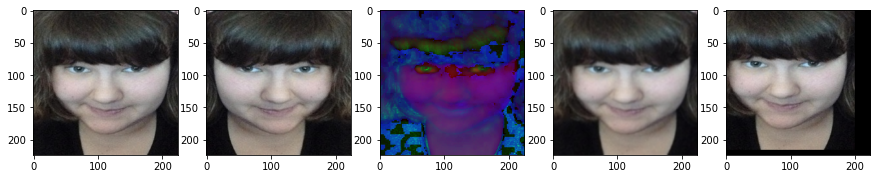

In [30]:
X_train = np.load('./data/data_train.npy')
x = X_train[random.randint(0, len(X_train))]
# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(flip(x), cv2.COLOR_BGR2RGB)) # pixel dropout
ax3.imshow(cv2.cvtColor(random_brightness(x), cv2.COLOR_BGR2RGB)) # rotation
ax4.imshow(cv2.cvtColor(blur(x), cv2.COLOR_BGR2RGB)) # croping
ax5.imshow(cv2.cvtColor(random_translation(x), cv2.COLOR_BGR2RGB)) # color channel inversion

4 new transformations

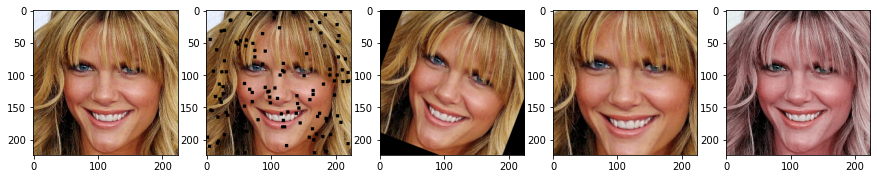

In [28]:
X_train = np.load('./data/data_train.npy')
x = X_train[random.randint(0, len(X_train))]
# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(random_pixel_dropout(x), cv2.COLOR_BGR2RGB)) # pixel dropout
ax3.imshow(cv2.cvtColor(random_image_rotation(x), cv2.COLOR_BGR2RGB)) # rotation
ax4.imshow(cv2.cvtColor(random_crop(x), cv2.COLOR_BGR2RGB)) # croping
ax5.imshow(cv2.cvtColor(random_channel_inversion(x), cv2.COLOR_BGR2RGB)) # color channel inversion

In [31]:
#Meta Information about age groups
def compute_MA_train(Y_train): 
  MA_train = M_train[:,0].copy()
  for i in range(len(Y_train)):
      if(Y_train[i]*100<20):
          MA_train[i] = "group 1"
      if(Y_train[i]*100>=20 and Y_train[i]<40):
          MA_train[i] = "group 2"
      if(Y_train[i]*100>=40 and Y_train[i]<60):
          MA_train[i] = "group 3"
      if(Y_train[i]*100>=60):
          MA_train[i] = "group 4"
  return MA_train

In [32]:
import numpy as np
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
M_train = np.load('./data/meta_data_train.npy')
MA_train = compute_MA_train(Y_train) 

We are going to compute the sub-groups that we define as the cross product GenderxAgexEthnicityxFace. For example an Happy Cauccasian Female from age Group 1 is a sub-group.

We will detect and augment the under-represented sub-groups

In [33]:
groups = np.array([" ".join(list(M_train[i][1:]) + [MA_train[i]]) for i in range(len(X_train))])
groups = {i : (groups == i).sum() for i in np.unique(groups)}

groups = {k: v for k, v in sorted(groups.items(), key=lambda item: item[1], reverse=True)}

groups

{'caucasian slightlyhappy group 2': 937,
 'caucasian neutral group 2': 619,
 'caucasian happy group 2': 393,
 'caucasian slightlyhappy group 3': 310,
 'caucasian neutral group 1': 287,
 'caucasian slightlyhappy group 1': 263,
 'caucasian neutral group 3': 235,
 'asian slightlyhappy group 2': 141,
 'caucasian happy group 3': 119,
 'asian neutral group 2': 86,
 'caucasian happy group 1': 84,
 'caucasian other group 2': 77,
 'caucasian neutral group 4': 69,
 'asian happy group 2': 54,
 'caucasian slightlyhappy group 4': 45,
 'asian neutral group 1': 43,
 'asian slightlyhappy group 1': 39,
 'caucasian other group 1': 39,
 'afroamerican slightlyhappy group 2': 28,
 'afroamerican neutral group 2': 26,
 'afroamerican happy group 2': 21,
 'asian neutral group 3': 21,
 'caucasian other group 3': 20,
 'caucasian happy group 4': 16,
 'asian happy group 1': 11,
 'asian slightlyhappy group 3': 11,
 'afroamerican happy group 1': 10,
 'afroamerican neutral group 3': 9,
 'caucasian other group 4': 9,


In [34]:
to_augment = {}

for k in groups:
  if groups[k] < 100:
    #Each under-represented sub-groups will be augmented 8x (number of transformations we have)
    to_augment[k] = 8 
to_augment, np.sum([k[1]for k in list(to_augment.items())])

({'asian neutral group 2': 8,
  'caucasian happy group 1': 8,
  'caucasian other group 2': 8,
  'caucasian neutral group 4': 8,
  'asian happy group 2': 8,
  'caucasian slightlyhappy group 4': 8,
  'asian neutral group 1': 8,
  'asian slightlyhappy group 1': 8,
  'caucasian other group 1': 8,
  'afroamerican slightlyhappy group 2': 8,
  'afroamerican neutral group 2': 8,
  'afroamerican happy group 2': 8,
  'asian neutral group 3': 8,
  'caucasian other group 3': 8,
  'caucasian happy group 4': 8,
  'asian happy group 1': 8,
  'asian slightlyhappy group 3': 8,
  'afroamerican happy group 1': 8,
  'afroamerican neutral group 3': 8,
  'caucasian other group 4': 8,
  'afroamerican neutral group 1': 8,
  'afroamerican other group 2': 8,
  'afroamerican slightlyhappy group 1': 8,
  'asian other group 1': 8,
  'afroamerican other group 1': 8,
  'asian slightlyhappy group 4': 8,
  'asian neutral group 4': 8,
  'afroamerican happy group 3': 8,
  'asian happy group 3': 8,
  'asian other group 2

In [35]:
def regular_data_augmentation(to_augment, X_train, Y_train, M_train):
  # aux variables
  X_train_augmented = []
  Y_train_augmented = []
  M_train_augmented = []
  print('Train set before augmentation = ', np.array(X_train).shape)

  #List of all the transformation we will apply
  transformations = [flip, random_brightness, blur, random_translation, random_pixel_dropout, 
                      random_image_rotation, random_crop,random_channel_inversion]
  cmpt = 0
  i = 0
  # augmenting the data
  for i in range(len(X_train)):
    sub_gr = " ".join(list(M_train[i][1:]) + [MA_train[i]])
    if sub_gr in to_augment:
      k = to_augment[sub_gr]
      temp = transformations.copy()
      random.shuffle(temp) #Will be usefull when we transform one image less than 8x (next part)
      for kk in range(k):
        fct = temp.pop(0)
        X_train_augmented.append(fct(X_train[i]))
        Y_train_augmented.append(Y_train[i])
        M_train_augmented.append(M_train[i])

  # adding the augmented images to the train set
  X_train = np.concatenate((X_train, X_train_augmented))
  Y_train = np.concatenate((Y_train, Y_train_augmented))
  M_train =  np.concatenate((M_train, M_train_augmented))

  print('Train set after augmentation = ', np.array(X_train).shape)
  return X_train, Y_train, M_train

In [36]:
X_train, Y_train, M_train = regular_data_augmentation(to_augment, X_train, Y_train, M_train)

Train set before augmentation =  (4065, 224, 224, 3)
Train set after augmentation =  (10153, 224, 224, 3)


In [37]:
MA_train = compute_MA_train(Y_train)
for i in range(M_train.shape[-1]):
  for k in np.unique(M_train[:,i]):
    print(k, " : ", (M_train[:,i] == k).sum())

for k in np.unique(MA_train):
  print(k, " : ", (MA_train == k).sum())

female  :  4885
male  :  5268
afroamerican  :  1071
asian  :  2688
caucasian  :  6394
happy  :  2312
neutral  :  3508
other  :  1485
slightlyhappy  :  2848
group 1  :  2764
group 2  :  4781
group 3  :  1276
group 4  :  1332


In [38]:
save_path_DA2 = '/content/drive/MyDrive/temp/best_model_2nd_stage_augmentation_DA2.h5'
history_DA2 = train(save_path_DA2, epochs = 15)

47/47 [==============================] - 13s 78ms/step


MAE (validation) = 8.10611480
Age analysis:
Size group 1 = 305, MAE = 10.712132
Size group 2 = 841, MAE = 6.502198
Size group 3 = 275, MAE = 8.687640
Size group 4 = 61, MAE = 14.567414
---------
Age bias (Ba) =  4.370023409525554
Gender analysis:
Size group female = 716, MAE = 7.987619
Size group male = 766, MAE = 8.216876
---------
Gender bias (Bg) =  0.2292571
Ethnicity Analysis:
Size group asian = 116, MAE = 7.266204
Size group afroamerican = 50, MAE = 7.027882
Size group caucasian = 1316, MAE = 8.221116
---------
Ethnicity bias (Be) =  0.7954896291097006
Face experession Analysis:
Size group happy = 403, MAE = 7.843288
Size group slightlyhappy = 476, MAE = 8.151057
Size group neutral = 492, MAE = 8.016737
Size group other = 111, MAE = 9.263783
---------
Face Expression bias (Bf) =  0.7326339880625407
0.4
0.4
0.4
0.4


NameError: ignored

<Figure size 640x480 with 0 Axes>

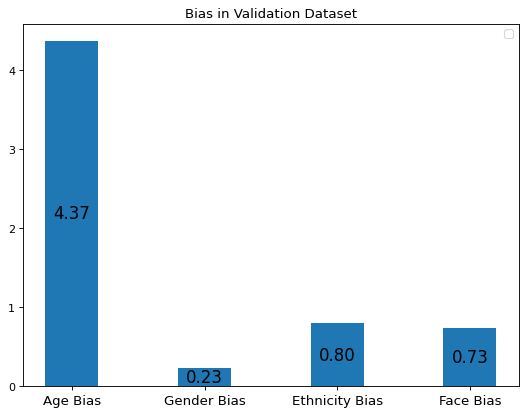

In [39]:
predictions_st2_augmented_DA2 = make_valid_preds(save_path_DA2, False)

plot_bias(predictions_st2_augmented_DA2, title = "Bias in Validation Dataset")
np.save('/content/drive/MyDrive/temp/best_model_2nd_stage_DA2_history.npy',history_DA2.history)

### Let's try to improve this

We can see that the previous method also improve the number of images of some already over-represented groups like "cauccasian". We then decide to not always augment the images 8 times, sometimes, for the over-represented group we will do it less than 8x.

In [ ]:
import numpy as np
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
M_train = np.load('./data/meta_data_train.npy')
MA_train = compute_MA_train(Y_train)

In [ ]:
to_augment = {}

for k in groups:
  if groups[k] < 100:
    if "group 2" in k:
      to_augment[k] = 2
    else:
      to_augment[k] = 8
  elif "group 1" in k:
    to_augment[k] = 4
  if "group 4" in k or "other" in k:
    to_augment[k] = 8

to_augment, np.sum([k[1]for k in list(to_augment.items())])

In [ ]:
X_train, Y_train, M_train = regular_data_augmentation(to_augment, X_train, Y_train, M_train)

In [ ]:
MA_train = compute_MA_train(Y_train)
for i in range(M_train.shape[-1]):
  for k in np.unique(M_train[:,i]):
    print(k, " : ", (M_train[:,i] == k).sum())

for k in np.unique(MA_train):
  print(k, " : ", (MA_train == k).sum())

In [ ]:
save_path_DA3 = '/content/drive/MyDrive/temp/best_model_2nd_stage_augmentation_DA3.h5'
history_DA3 = train(save_path_DA3, epochs = 15)
np.save('/content/drive/MyDrive/temp/best_model_2nd_stage_DA3_history.npy',history_DA3.history)

47/47 [==============================] - 4s 71ms/step
MAE (validation) = 7.69045966
Age analysis:
Size group 1 = 305, MAE = 7.331953
Size group 2 = 841, MAE = 6.186429
Size group 3 = 275, MAE = 11.102460
Size group 4 = 61, MAE = 14.836923
---------
Age bias (Ba) =  4.953664779663086
Gender analysis:
Size group female = 716, MAE = 7.489449
Size group male = 766, MAE = 7.878350
---------
Gender bias (Bg) =  0.38890123
Ethnicity Analysis:
Size group asian = 116, MAE = 6.079135
Size group afroamerican = 50, MAE = 6.232512


Size group caucasian = 1316, MAE = 7.887885
---------
Ethnicity bias (Be) =  1.205832799275716
Face experession Analysis:
Size group happy = 403, MAE = 7.560670
Size group slightlyhappy = 476, MAE = 7.791624
Size group neutral = 492, MAE = 7.240663
Size group other = 111, MAE = 9.721548
---------
Face Expression bias (Bf) =  1.2789347966512044
0.4
0.4
0.4
0.4


<Figure size 640x480 with 0 Axes>

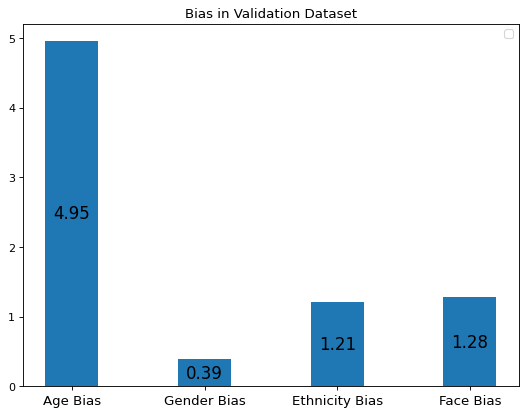

In [40]:
predictions_st2_augmented_DA3 = make_valid_preds(save_path_DA3, False)
plot_bias(predictions_st2_augmented_DA3, title = "Bias in Validation Dataset")

## Method 2 : Data Augmentation using Aging GAN

We will use a GAN to Age people face. We hope that this will reduce significantly the Age Bias. 

The pre-trained model comes from https://github.com/yuval-alaluf/SAM. It's one of the very few github with pre-trained GAN.

We also wanted to do gender transformation by training a DiscoGAN (https://github.com/RomainMsrd/DiscoGAN-pytorch) on the Appa-Real Age Dataset. Unfortunately, after 4 hours of training the result didn't look great and we choose to not pursue.

The data generation is quite slow, this why after the fisrt generation we put the data on google drive so that you can download it instead of running the data generation.

In [48]:
DOWLOAD_AUGMENTED_DATA = True #Put to false to generate the data
if DOWLOAD_AUGMENTED_DATA:
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR" -O "DA_data.zip" && rm -rf /tmp/cookies.txt

  with ZipFile('DA_data.zip','r') as zip:
    zip.extractall(path = "./data")
    print('Augemented Data decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm DA_data.zip
else :

  import os
  os.chdir('/content')
  CODE_DIR = 'SAM'

  !git clone https://github.com/yuval-alaluf/SAM.git $CODE_DIR
  !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
  !sudo unzip ninja-linux.zip -d /usr/local/bin/
  !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

  os.chdir(f'./{CODE_DIR}')
  from argparse import Namespace
  import os
  import sys
  import pprint
  import numpy as np
  from PIL import Image
  import torch
  import torchvision.transforms as transforms

  sys.path.append(".")
  sys.path.append("..")

  from datasets.augmentations import AgeTransformer
  from utils.common import tensor2im
  from models.psp import pSp

  import random

  EXPERIMENT_TYPE = 'ffhq_aging'

  def get_download_model_command(file_id, file_name):
      """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
      current_directory = os.getcwd()
      save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
      if not os.path.exists(save_path):
          os.makedirs(save_path)
      url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
      return url    
      
  MODEL_PATHS = {
      "ffhq_aging": {"id": "1XyumF6_fdAxFmxpFcmPf-q84LU_22EMC", "name": "sam_ffhq_aging.pt"}
  }

  path = MODEL_PATHS[EXPERIMENT_TYPE]
  download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

  !wget {download_command}

  !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
  !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

  model_path = "../pretrained_models/sam_ffhq_aging.pt"
  ckpt = torch.load(model_path, map_location='cpu')

  opts = ckpt['opts']
  pprint.pprint(opts)

  # update the training options
  opts['checkpoint_path'] = model_path

  opts = Namespace(**opts)
  net = pSp(opts)
  net.eval()
  net.cuda()
  print('Model successfully loaded!')

  import AgingGan
  from AgingGan import aging_gan

  X_train_augmented = []
  Y_train_augmented = []
  M_train_augmented = []

  for i in range(len(Y_train)):
    if Y_train[i]< 40:
      try:
        target_age = random.randint(40,100)
        img_path = "SAM/notebooks/images/test.jpg"
        cv2.imwrite(img_path, X_train[i])
        result = aging_gan(net, img_path, target_age).resize((224,224))
        X_train_augmented.append(np.array(result))
        Y_train_augmented.append(target_age)
        M_train_augmented.append(M_train[i])
      except:
        print("\r", end = "")
        print(f'No visage found in this image', end = "")
    
    if i%100 == 0:
      print("\r", end = "")
      print(f'{int(i/len(Y_train)*100)}%', end = "")
      
  np.save("./data/X_train_Age_GAN.npy", np.array(X_train_augmented))
  np.save("./data/Y_train_Age_GAN.npy", np.array(Y_train_augmented))
  np.save("./data/M_train_Age_GAN.npy", np.array(M_train_augmented))


--2022-10-06 21:26:16--  https://docs.google.com/uc?export=download&confirm=t&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR
Resolving docs.google.com (docs.google.com)... 142.250.4.101, 142.250.4.138, 142.250.4.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fq61u7hlqntqlpmc0kbhorb9fjn7vj3s/1665091575000/06723580391369273007/*/1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR?e=download&uuid=234fefdd-4a4c-4751-ba20-a805aebe3508 [following]
--2022-10-06 21:26:18--  https://doc-0k-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fq61u7hlqntqlpmc0kbhorb9fjn7vj3s/1665091575000/06723580391369273007/*/1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR?e=download&uuid=234fefdd-4a4c-4751-ba20-a805aebe3508
Resolving doc-0k-ag-docs.googleusercontent.com (doc-0k-ag-docs.googleusercontent.com)... 172.217.194.132, 240

In [49]:
X_train_augmented = np.load('./data/X_train_Age_GAN.npy')
Y_train_augmented = np.load('./data/Y_train_Age_GAN.npy')
#Y_train_augmented = Y_train_augmented/100
M_train_augmented = np.load('./data/M_train_Age_GAN.npy')
X_train_augmented = np.array([cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR) for im in X_train_augmented])

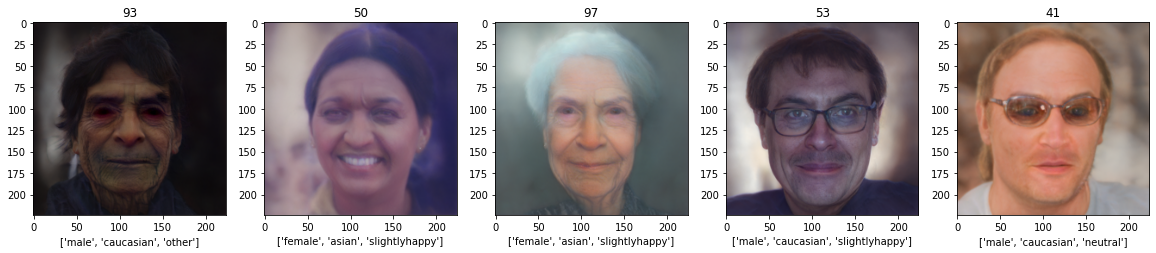

In [50]:
#Example of augmented data
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train_augmented))
    ax.imshow(cv2.cvtColor(X_train_augmented[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train_augmented[idx])
    ax.set(xlabel=[M_train_augmented[idx][0],M_train_augmented[idx][1],M_train_augmented[idx][2]])

In [ ]:
# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
Y_train = Y_train/100
M_train =  np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)


# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

In [ ]:
save_path_DA_GAN = '/content/drive/MyDrive/temp/best_model_2nd_stage_augmentation_DA_GAN.h5'
history_DA_GAN = train(save_path_DA_GAN, epochs = 15)
np.save('/content/drive/MyDrive/temp/best_model_2nd_stage_DA_GAN_history.npy',history_DA_GAN.history)

In [41]:
predictions_st2_augmented_DA_GAN = make_valid_preds(save_path_DA_GAN, False)

47/47 [==============================] - 4s 72ms/step
MAE (validation) = 8.74932290


Age analysis:
Size group 1 = 305, MAE = 9.250286
Size group 2 = 841, MAE = 7.404756
Size group 3 = 275, MAE = 10.402597
Size group 4 = 61, MAE = 17.328609
---------
Age bias (Ba) =  5.15397834777832
Gender analysis:


Size group female = 716, MAE = 8.540776
Size group male = 766, MAE = 8.944257
---------
Gender bias (Bg) =  0.40348053
Ethnicity Analysis:
Size group asian = 116, MAE = 8.342705
Size group afroamerican = 50, MAE = 7.684237
Size group caucasian = 1316, MAE = 8.825632
---------
Ethnicity bias (Be) =  0.760930061340332
Face experession Analysis:
Size group happy = 403, MAE = 8.903339
Size group slightlyhappy = 476, MAE = 8.701168
Size group neutral = 492, MAE = 8.638352
Size group other = 111, MAE = 8.888516
---------
Face Expression bias (Bf) =  0.16371822357177734
0.4
0.4
0.4
0.4


<Figure size 640x480 with 0 Axes>

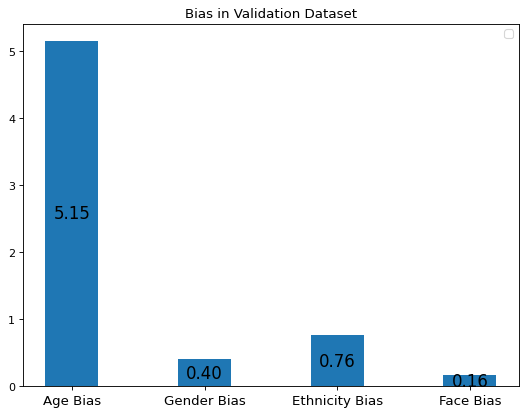

In [42]:
plot_bias(predictions_st2_augmented_DA_GAN, title = "Bias in Validation Dataset")

## Method 3 : Combinign Both Method

In [ ]:
X_train, Y_train, M_train = regular_data_augmentation(to_augment, X_train, Y_train, M_train) #Do Improved DA and automatically reload X_train, Y_train and M_train

In [ ]:
X_train_augmented = np.load('./data/X_train_Age_GAN.npy')
Y_train_augmented = np.load('./data/Y_train_Age_GAN.npy')
M_train_augmented = np.load('./data/M_train_Age_GAN.npy')

print(len(X_train_augmented))

#We only keep people between 60 and 90 yo
#Because there is not a lot of people older than 90 in the dataset
mask = ((Y_train_augmented > 60).astype(int) + (Y_train_augmented < 90).astype(int)) == 2

X_train_augmented = X_train_augmented[mask]
Y_train_augmented = Y_train_augmented[mask]
Y_train_augmented = Y_train_augmented/100
M_train_augmented = M_train_augmented[mask]
print(len(X_train_augmented))

In [ ]:
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train =  np.concatenate((M_train, M_train_augmented))

print('Train set after GAN augmentation = ', np.array(X_train).shape)

In [ ]:
save_path_DA_GAN2 = '/content/drive/MyDrive/temp/best_model_2nd_stage_augmentation_DA_GAN2.h5'
history_DA_GAN2 = train(save_path_DA_GAN2, epochs = 15)
np.save('/content/drive/MyDrive/temp/best_model_2nd_stage_DA_GAN2_history.npy',history_DA_GAN2.history)

In [43]:
predictions_st2_augmented_DA_GAN2 = make_valid_preds(save_path_DA_GAN2, False)

47/47 [==============================] - 4s 72ms/step
MAE (validation) = 7.60583847


Age analysis:
Size group 1 = 305, MAE = 7.042501
Size group 2 = 841, MAE = 6.317840
Size group 3 = 275, MAE = 10.277756
Size group 4 = 61, MAE = 16.134493
---------
Age bias (Ba) =  5.4475351969401045
Gender analysis:
Size group female = 716, MAE = 7.762817
Size group male = 766, MAE = 7.459107
---------
Gender bias (Bg) =  0.30370998
Ethnicity Analysis:
Size group asian = 116, MAE = 6.425447
Size group afroamerican = 50, MAE = 6.352901
Size group caucasian = 1316, MAE = 7.757489
---------
Ethnicity bias (Be) =  0.9363921483357748
Face experession Analysis:
Size group happy = 403, MAE = 7.890963
Size group slightlyhappy = 476, MAE = 7.796430
Size group neutral = 492, MAE = 6.957018
Size group other = 111, MAE = 8.629194
---------
Face Expression bias (Bf) =  0.851843516031901
0.4
0.4
0.4
0.4


<Figure size 640x480 with 0 Axes>

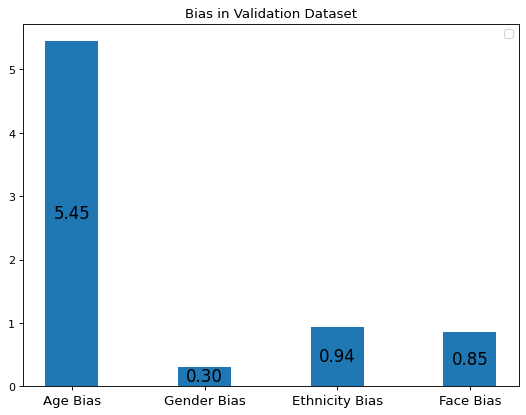

In [44]:
plot_bias(predictions_st2_augmented_DA_GAN2, title = "Bias in Validation Dataset")

## Conclusion for Data Augmentation:

47/47 [==============================] - 4s 73ms/step
Age analysis:
Size group 1 = 305, MAE = 10.712132
Size group 2 = 841, MAE = 6.502198
Size group 3 = 275, MAE = 8.687640
Size group 4 = 61, MAE = 14.567414
---------
Age bias (Ba) =  4.370023409525554
Gender analysis:
Size group female = 716, MAE = 7.987619
Size group male = 766, MAE = 8.216876
---------
Gender bias (Bg) =  0.2292571
Ethnicity Analysis:
Size group asian = 116, MAE = 7.266204
Size group afroamerican = 50, MAE = 7.027882
Size group caucasian = 1316, MAE = 8.221116
---------
Ethnicity bias (Be) =  0.7954896291097006
Face experession Analysis:
Size group happy = 403, MAE = 7.843288
Size group slightlyhappy = 476, MAE = 8.151057
Size group neutral = 492, MAE = 8.016737
Size group other = 111, MAE = 9.263783
---------
Face Expression bias (Bf) =  0.7326339880625407
47/47 [==============================] - 4s 72ms/step
Age analysis:
Size group 1 = 305, MAE = 7.331953
Size group 2 = 841, MAE = 6.186429
Size group 3 = 275, MA

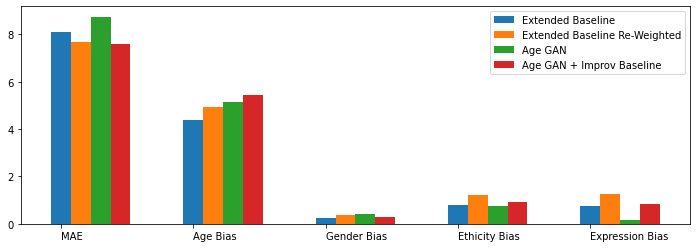

In [47]:
 models_name = {save_path_DA2:"Extended Baseline", save_path_DA3:"Extended Baseline Re-Weighted", 
               save_path_DA_GAN:"Age GAN", save_path_DA_GAN2:"Age GAN + Improv Baseline"
}

list_models = {
    save_path_DA2:[], save_path_DA3:[], save_path_DA_GAN:[], save_path_DA_GAN2:[]
}
for i, model_name in enumerate(list_models):
    list_models[model_name] = eval_model(model_name)

list_attr = ["MAE","Age Bias","Gender Bias","Ethicity Bias","Expression Bias"]
X_axis = np.arange(len(list_attr))
width = 0.15

plt.figure(figsize=(12,4))
for i, model_name in enumerate(list_models):
    plt.bar(X_axis+width*i, list_models[model_name], width, label = models_name[model_name])
    
plt.xticks(X_axis, list_attr, horizontalalignment='left')
plt.legend()
plt.show()

# 💫 Bias Mitigation (LOSS)


## Methods of combining the weights

### Load the Train data again (to remove the augmented data) and generate the weigths 
- First, we will generate a weight for each age group (for g =1 to 4);
- The formula used to calculate the weight for each group $j$ is:

  $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

  Where

    - $w_j$ is the weight for each group $j$,
    - $n_{samples}$ is the number of samples in the train set,
    - $n_{classes}$ is the number of classes (4 in our case, as we divided the ages in 4 groups),
    - $n_{samples,j}$ is the number of samples of class (group) $j$.


### Option 1: **PRODUCT of weights**

In [ ]:
# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0, Y_train.shape[0]):
    if Y_train[i] * 100 < 20:
        g1 += 1
    if Y_train[i] * 100 >= 20 and Y_train[i] * 100 < 40:
        g2 += 1
    if Y_train[i] * 100 >= 40 and Y_train[i] * 100 < 60:
        g3 += 1
    if Y_train[i] * 100 >= 60:
        g4 += 1
print("group(s) size = ", [g1, g2, g3, g4])

# generating the weights for each group using the equation defined above
w = sum(np.array([g1, g2, g3, g4])) / (4 * np.array([g1, g2, g3, g4]))
print("weights per group = ", w)

# creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights = []
for i in range(0, Y_train.shape[0]):
    if Y_train[i] * 100 < 20:
        sample_weights.append(w[0])
    if Y_train[i] * 100 >= 20 and Y_train[i] * 100 < 40:
        sample_weights.append(w[1])
    if Y_train[i] * 100 >= 40 and Y_train[i] * 100 < 60:
        sample_weights.append(w[2])
    if Y_train[i] * 100 >= 60:
        sample_weights.append(w[3])
sample_weights_age = np.array(sample_weights)


group(s) size =  [796, 2389, 732, 148]
weights per group =  [1.27669598 0.42538719 1.38831967 6.86655405]


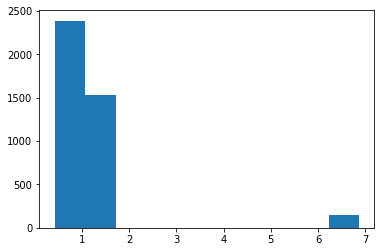

In [ ]:
# plot sample weights
plt.hist(sample_weights_age)
plt.show()


In [ ]:
M_train_categorical = M_train.copy()

for i in range(0, M_train_categorical.shape[1]):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(M_train_categorical[:, i])
    M_train_categorical[:, i] = integer_encoded

M_train_categorical


array([['1', '2', '1'],
       ['0', '2', '1'],
       ['0', '2', '3'],
       ...,
       ['1', '2', '1'],
       ['1', '2', '1'],
       ['0', '2', '0']], dtype='<U13')

In [ ]:
# calculate the number of unique values in each column
num_unique_values = []
num_unique_values_dict = []
for i in range(0, M_train_categorical.shape[1]):
    unique, counts = np.unique(M_train_categorical[:, i], return_counts=True)
    num_unique_values.append(counts)
    num_unique_values_dict.append(dict(zip(unique, counts)))

print(num_unique_values_dict)
weights = []
for values in num_unique_values:
    w = sum(values) / (4 * values)
    print("weights per group = ", w)
    weights.append(w)

weights


[{'0': 1997, '1': 2068}, {'0': 119, '1': 424, '2': 3522}, {'0': 712, '1': 1404, '2': 165, '3': 1784}]
weights per group =  [0.50888833 0.49141683]
weights per group =  [8.53991597 2.39681604 0.28854344]
weights per group =  [1.42731742 0.72382479 6.15909091 0.56964686]


[array([0.50888833, 0.49141683]),
 array([8.53991597, 2.39681604, 0.28854344]),
 array([1.42731742, 0.72382479, 6.15909091, 0.56964686])]

In [ ]:
sample_weights_categorical = []
for i, sample in enumerate(M_train_categorical):
    norm_weights = []
    for j, value in enumerate(sample):
        norm_weights.append(weights[j][int(value)])

    sample_weights_categorical.append(np.product(norm_weights))

sample_weights_categorical = np.array(sample_weights_categorical)


In [ ]:
sample_weights_final = np.array(sample_weights_categorical) * np.array(sample_weights_age)
sample_weights_final


array([0.13103345, 0.04521178, 0.57435215, ..., 0.04365953, 0.04365953,
       0.26757267])

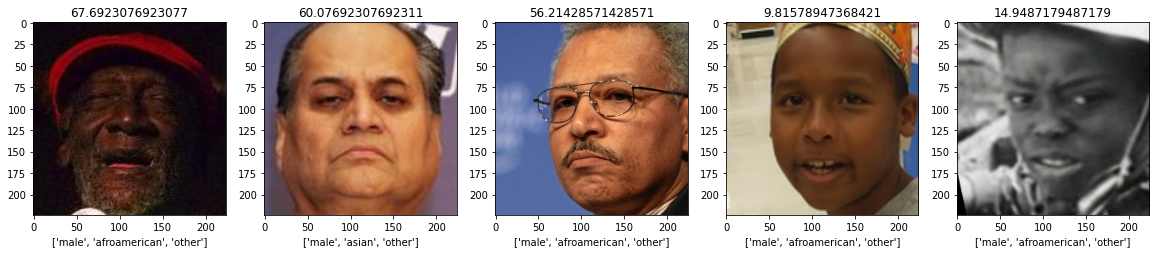

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
idx_sorted = np.argsort(sample_weights_final)[::-1][:5]
for i, ax in enumerate(axes):
    idx = idx_sorted[i]
    ax.imshow(cv2.cvtColor(X_train[idx, :, :, :], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx] * 100)
    ax.set(xlabel=[M_train[idx][0], M_train[idx][1], M_train[idx][2]])


### Option 2: **MAX of weights**

- Taking MAX across all weights


In [ ]:
sample_weights_categorical = []
for i, sample in enumerate(M_train_categorical):
    norm_weights = []
    for j, value in enumerate(sample):
        norm_weights.append(weights[j][int(value)])

    sample_weights_categorical.append(np.max(norm_weights))

sample_weights_categorical = np.array(sample_weights_categorical)


In [ ]:
# merge sample_weights_categorical and sample_weights along the rows
sample_weights_final = np.zeros((sample_weights_categorical.shape[0], 2))
sample_weights_final[:, 0] = sample_weights_categorical
sample_weights_final[:, 1] = sample_weights_age

sample_weights_final


array([[0.72382479, 1.27669598],
       [0.72382479, 0.42538719],
       [0.56964686, 6.86655405],
       ...,
       [0.72382479, 0.42538719],
       [0.72382479, 0.42538719],
       [1.42731742, 1.27669598]])

In [ ]:
sample_weights_final = np.max(sample_weights_final, axis=1)
sample_weights_final


array([1.27669598, 0.72382479, 6.86655405, ..., 0.72382479, 0.72382479,
       1.42731742])

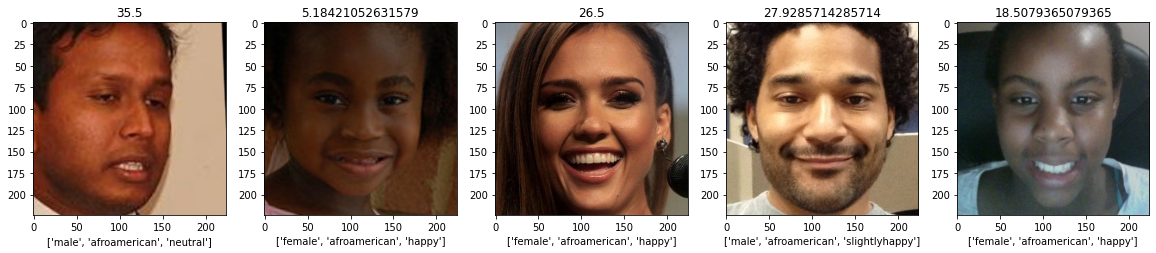

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
idx_sorted = np.argsort(sample_weights_final)[::-1][:5]
for i, ax in enumerate(axes):
    idx = idx_sorted[i]
    ax.imshow(cv2.cvtColor(X_train[idx, :, :, :], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx] * 100)
    ax.set(xlabel=[M_train[idx][0], M_train[idx][1], M_train[idx][2]])


## Methods of computing the weights 

We compare different approaches to computing sample weights. 
* The **standard** method proposed in the starting kit is a very common standard formula:
$$ 
w_j = \frac{n_{samples}}{(n_{classes} * n_{samples,j})}
$$
* Inverse  of Number of Samples (**INS**):
$$
w_j = \frac{1}{n_{samples,j}} 
$$
* Inverse of Square Root of Number of Samples (**ISNS**):
$$
w_j = \frac{1}{\sqrt{n_{samples,j}}}
$$
* Effective Number of Samples (**ENS**):
$$
w_j = \frac{1-\beta}{1-\beta^{n_{samples,j}}}
$$
ENS was introduced in CVPR’19 by researches from Google [arXiv:1901.05555](https://arxiv.org/pdf/1901.05555.pdf).The intuition behind is that the additional benefit of adding a new data point will diminish as the number of samples increases. Here $\beta \in [0,1[$ is a hyperparameter, authors recommend taking values like 0.9, 0.99, 0.999…. We take 0.999 based on authors’ results.
* Scaled Effective Number of Samples (**Scaled_ENS**):
$$
w_j = \lambda * \frac{1-\beta}{1-\beta^{n_{samples,j}}}
$$
we noticed that weights obtained with ENS were in the order of 1e-3. So we also experimented with a “scaled ENS”, multiplying the sample weights by a scalar $\lambda$.

Some helper functions :

In [ ]:
# training function
def train(sample_weights, model_path, num_epoch):
  """trains a resnet50 in second stage

  Args:
      sample_weights (array : int): sample weights to pass to the fit method of tensorflow 
      model_path (str): the path for the model
      num_epoch (int): number of the epochs for the training
  """

  # preprocessing the train data with respect to ResNet-50 Inputs.
  for i in range(0,X_train.shape[0]):
    x = X_train[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

  # loading the saved model (best model learned at stage 1)
  saved_model = tf.keras.models.load_model('best_model.h5') # load model from stage 1
  
  # setting all layers to traineble
  saved_model.trainable = True

  #=================================================
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
  #=================================================

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=num_epoch, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
  saved_model.save(model_path)

# weights functions
def compute_weights(group_size, formula, scalar=1):
  """computes the weights of classes

  Args:
      group_size (array: float): the size of each class
      formula (str): the formula to use for computing the weights
      scalar (int, optional): the scalar for the weights. Defaults to 1.

  Returns:
      array: the weights for each class
  """
  group_size = np.array(group_size)
  if formula=="standard":
      w = sum(group_size)/(len(group_size)*group_size)
  elif formula=="ins":
      w = 1/group_size
  elif formula=="isns":
      w = 1/np.sqrt(group_size)
  elif formula=="ens":
      beta = 0.999
      w = (1-beta)/(1-beta**group_size)
  elif formula=="scaled_ens":
      beta = 0.999
      w = (1-beta)/(1-beta**group_size)
      w*= scalar
  else:
      print(f"unknown formula to compute weights {(formula)}")
      w = None
  return w

def get_sample_weights(formula, scalar=1):
  """generatess the sample weights

  Args:
      formula (str): the formula to use for computing the weights
      scalar (int, optional): the scalar for the weights. Defaults to 1.

  Returns:
      array: sample weights that can be passed to the fit model for the training
  """

  # compute the group size of age
  age_group_size = [0]*4
  for i in range(0,Y_train.shape[0]):
      if(Y_train[i]*100<20):
        age_group_size[0] +=1
      if(Y_train[i]*100>=20 and Y_train[i]*100<40):
        age_group_size[1] +=1
      if(Y_train[i]*100>=40 and Y_train[i]*100<60):
        age_group_size[2] +=1
      if(Y_train[i]*100>=60):
        age_group_size[3] +=1

  # compute the group size of pther categories
  values, counts = np.unique(M_train[:,0], return_counts=True)
  gender_group_size = dict(zip(values, counts))
  values, counts = np.unique(M_train[:,1], return_counts=True)
  eth_group_size = dict(zip(values, counts))
  values, counts = np.unique(M_train[:,2], return_counts=True)
  exp_group_size = dict(zip(values, counts))

  # compute the weights for each class
  age_weights = compute_weights(age_group_size,formula, scalar)
  gender_weights = dict(zip(gender_group_size.keys(),compute_weights(list(gender_group_size.values()),formula, scalar)))
  eth_weights = dict(zip(eth_group_size.keys(),compute_weights(list(eth_group_size.values()),formula, scalar)))
  exp_weights = dict(zip(exp_group_size.keys(),compute_weights(list(exp_group_size.values()),formula, scalar)))

  # generate the sample weights
  sample_weights = {'age':[],'gender':[],'eth':[],'exp':[]}
  
  for i in range(0,Y_train.shape[0]):

    sample_weights['gender'].append(gender_weights[M_train[i][0]])
    sample_weights['eth'].append(eth_weights[M_train[i][1]])
    sample_weights['exp'].append(exp_weights[M_train[i][2]])

    if(Y_train[i]*100<20):
      sample_weights['age'].append(age_weights[0])
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      sample_weights['age'].append(age_weights[1])
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      sample_weights['age'].append(age_weights[2])
    if(Y_train[i]*100>=60):
      sample_weights['age'].append(age_weights[3])

  # combine sample weights by taking the max
  final_sample_weights = np.array([list(sample_weights.values())]).max(axis=1)[0]

  return final_sample_weights

# evaluation function
def eval_model(model_path):
    """computes the scores of the model: MAE and all biases

    Args:
        model_path (str): the path for the model

    Returns:
        array: [MAE, Age Bias, Gender Bias, Ethicity Bias, Expression Bias]
    """
    model = tf.keras.models.load_model(model_path)
    pred = model.predict(X_valid, batch_size=32, verbose=1)
    pred = pred*100
    error = []
    for i in range(0,len(Y_valid)):
        error.append(abs(np.subtract(pred[i][0],Y_valid[i]*100)))
    # print('MAE (Validation) = %.8f' %(np.mean(error)))
    mae = np.mean(error)

    return np.array([mae,  \
        age_bias(pred,Y_valid*100),  \
        gender_bias(pred,Y_valid*100,M_valid),  \
        ethnicity_bias(pred,Y_valid*100,M_valid),  \
        face_expression_bias(pred,Y_valid*100,M_valid)])


# make_submission function
import csv

def make_submission(model_path):
    """_summary_

    Args:
        model_path (str): the path for the model
    """
    model = tf.keras.models.load_model(model_path)
    pred = model.predict(X_test, batch_size=32, verbose=1)
    pred = pred*100

    # saving the predictions as a csv file   
    with open('predictions.csv', 'w', newline='') as csvFile:  # using newline='' is important for windows users!!
        writer = csv.writer(csvFile)
        writer.writerows(pred)
    csvFile.close()

    # compressing the csv file (to be submitted to codalab as prediction)
    ! zip predictions.zip predictions.csv


training all models :

In [ ]:
list_models = {
    "standard(epoch=50)":["standard",50],"ins(epoch=50)":["ins",50],"isns(epoch=50)":["isns",50],
    "ens(epoch=50)":["ens",50],"scaled_ens(epoch=50)":["scaled_ens",50,100],
    "scaled_ens(epoch=100)":["scaled_ens",100,100]
}
for model_name in list_models:
    model_info = list_models[model_name]
    if not model_name.startswith("scaled_ens"):
        sample_weights = get_sample_weights(model_info[0])
    else:
        sample_weights = get_sample_weights(model_info[0], model_info[2])
    train(sample_weights, f"models/{model_name}", model_info[1])

evaluation the models on the validation set :

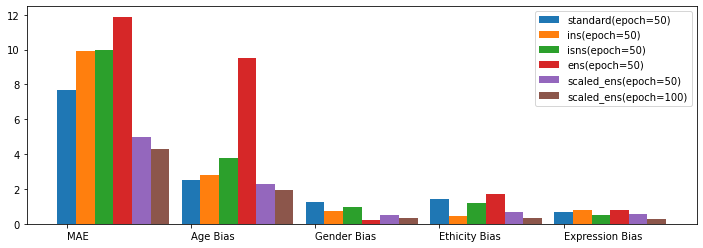

In [ ]:
# predictions on validation set
list_models = {
    "standard(epoch=50)":[],"ins(epoch=50)":[],"isns(epoch=50)":[],"ens(epoch=50)":[],
    "scaled_ens(epoch=50)":[],"scaled_ens(epoch=100)":[]
}
for i, model_name in enumerate(list_models):
    list_models[model_name] = eval_model(f'models/{model_name}')

list_attr = ["MAE","Age Bias","Gender Bias","Ethicity Bias","Expression Bias"]
X_axis = np.arange(len(list_attr))
width = 0.15

plt.figure(figsize=(12,4))
for i, model_name in enumerate(list_models):
    plt.bar(X_axis+width*i, list_models[model_name], width, label = model_name)
    
plt.xticks(X_axis, list_attr, horizontalalignment='left')
plt.legend()
plt.show()


make a submission with the best model :

In [ ]:
make_submission("models/scaled_ens(epoch=100)")

## **MinDiff**

MinDiff is a method for mitigating bias in machine learning models. It is based on the idea that the bias of a model can be reduced by minimizing the difference between the model’s predictions and the ground truth labels. MinDiff is based on the following two assumptions:

1. The bias of a model can be quantified by the difference between the model’s predictions and the ground truth labels.
2. The bias of a model can be reduced by minimizing the difference between the model’s predictions and the ground truth labels.

There is an official implemenation for the TensorFlow:
https://blog.tensorflow.org/2020/11/applying-mindiff-to-improve-model.html


Before, we need to identify minority group, since MinDiff is trained by creating 2 datasets: one for the majority group and one for the minority group.

In [ ]:
M_train_categorical = M_train.copy()
age_categorical = sample_weights_age.copy()


In [ ]:
for i in range(0, age_categorical.shape[0]):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(age_categorical)
    age_categorical = integer_encoded

for i in range(0, M_train_categorical.shape[1]):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(M_train_categorical[:, i])
    M_train_categorical[:, i] = integer_encoded


In [ ]:
# calculate the number of unique values in each column
num_unique_values = []
num_unique_values_dict = []
for i in range(0, M_train_categorical.shape[1]):
    unique, counts = np.unique(M_train_categorical[:, i], return_counts=True)
    num_unique_values.append(counts)
    num_unique_values_dict.append(dict(zip(unique, counts)))

print(num_unique_values_dict)


[{'0': 1997, '1': 2068}, {'0': 119, '1': 424, '2': 3522}, {'0': 712, '1': 1404, '2': 165, '3': 1784}]


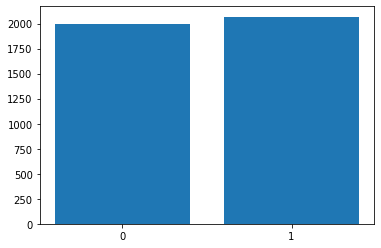

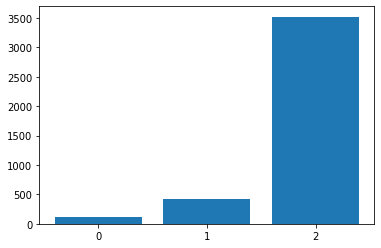

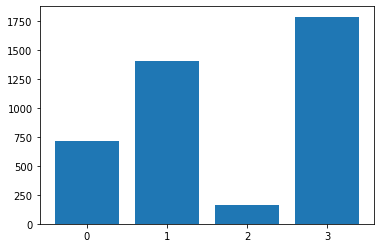

In [ ]:
for group_dict in num_unique_values_dict:
    # plot hist
    plt.figure()
    plt.bar(range(len(group_dict)), list(group_dict.values()), align="center")
    plt.xticks(range(len(group_dict)), list(group_dict.keys()))
    plt.show()


In [ ]:
gender = M_train_categorical[:, 0]
ethnicity = M_train_categorical[:, 1]
face_expression = M_train_categorical[:, 2]


In [ ]:
minority_mask = (
    (ethnicity == "0")
    ^ (ethnicity == "1")
    ^ (face_expression == "2")
    ^ (face_expression == "0")
    ^ (age_categorical == 3)
    ^ (age_categorical == 3)
)
minority_mask


array([False, False, False, ..., False, False,  True])

In [ ]:
len(X_train[minority_mask]), len(X_train[~minority_mask])


(1180, 2885)

### Train MinDiff model

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 30
EXPERIMENT_NAME = "mindiff"
LR = 1e-6

dataset_train_main = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(
    BATCH_SIZE
)
dataset_train_sensitive = tf.data.Dataset.from_tensor_slices(
    (X_train[minority_mask], Y_train[minority_mask])
).batch(BATCH_SIZE)
dataset_train_nonsensitive = tf.data.Dataset.from_tensor_slices(
    (X_train[~minority_mask], Y_train[~minority_mask])
).batch(BATCH_SIZE)

dataset_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE)


In [ ]:
len(X_train[minority_mask]), len(X_train[~minority_mask])


(1180, 2885)

In [ ]:
min_diff_weight = 1.5

# Create the dataset that will be passed to the MinDiffModel during training.
dataset = min_diff.keras.utils.input_utils.pack_min_diff_data(
    dataset_train_main, dataset_train_sensitive, dataset_train_nonsensitive
)


Authors of the MinDiff, mentioned that this method should be applied when whole model is trained. 

In [ ]:
# loading resnet50
saved_model = tf.keras.models.load_model(
    f"./temp/resnet50/best_model_2nd_stage.h5"
)

saved_model.trainable = True

In [ ]:
# Wrap the original model in a MinDiffModel, passing in one of the MinDiff
# losses and using the set loss_weight.
min_diff_loss = min_diff.losses.MMDLoss()
min_diff_model = min_diff.keras.MinDiffModel(
    saved_model, min_diff_loss, min_diff_weight
)

# Compile the model normally after wrapping the original model.  Note that
# this means we use the baseline's model's loss here.
min_diff_model.compile(
    tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mae"],
)

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10
)

history = min_diff_model.fit(
    dataset,
    validation_data=dataset_valid,
    epochs=NUM_EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es],
)

min_diff_model.save_original_model(
    f"./temp/{EXPERIMENT_NAME}/best_model_mindiff.h5", save_format="h5"
)

# saving training history (for future visualization)
with open(f"./temp/{EXPERIMENT_NAME}/train_history_mindiff.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


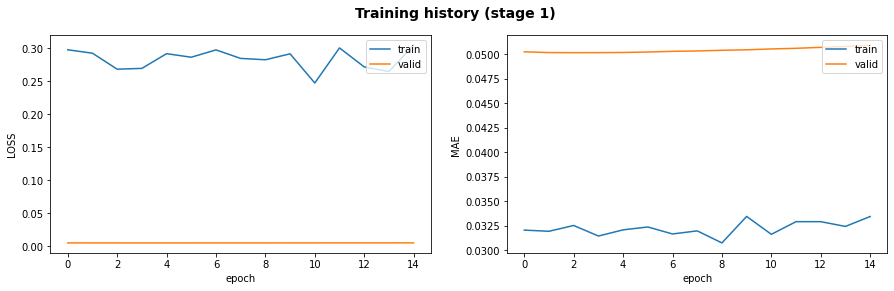

In [ ]:
train_hist = pickle.load(open(f"./temp/{EXPERIMENT_NAME}/train_history_mindiff.pkl", "rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("Training history (stage 1)", fontsize=14, fontweight="bold")

ax1.plot(train_hist["loss"])
ax1.plot(train_hist["val_loss"])
ax1.set(xlabel="epoch", ylabel="LOSS")
ax1.legend(["train", "valid"], loc="upper right")

ax2.plot(train_hist["mae"])
ax2.plot(train_hist["val_mae"])
ax2.set(xlabel="epoch", ylabel="MAE")
ax2.legend(["train", "valid"], loc="upper right")


In [ ]:
mae_evaluation(f"./temp/{EXPERIMENT_NAME}/best_model_mindiff.h5", X_valid, Y_valid)

## **Custom Loss**

For custom loss, we modified bias calculations and replaced numpy with tensorflow functions. Additionally, we added bias metric, so they can be monitored during training.

In [ ]:
def age_bias_loss(predictions, gt):
    error_g1 = []
    error_g2 = []
    error_g3 = []
    error_g4 = []
    
    G1 = 20
    G2 = 40 
    G3 = 60
    
    error_g1 = tf.keras.backend.abs(predictions[gt < G1] - gt[gt < G1])**2
    error_g2 = tf.keras.backend.abs(predictions[(gt >= G1) & (gt < G2)] - gt[(gt >= G1) & (gt < G2)])**2
    error_g3 = tf.keras.backend.abs(predictions[(gt >= G2) & (gt < G3)] - gt[(gt >= G2) & (gt < G3)])**2
    error_g4 = tf.keras.backend.abs(predictions[gt >= G3] - gt[gt >= G3])**2
    
    b1 = tf.keras.backend.abs(tf.keras.backend.mean(error_g1) - tf.keras.backend.mean(error_g2))
    b2 = tf.keras.backend.abs(tf.keras.backend.mean(error_g1) - tf.keras.backend.mean(error_g3))
    b3 = tf.keras.backend.abs(tf.keras.backend.mean(error_g1) - tf.keras.backend.mean(error_g4))
    b4 = tf.keras.backend.abs(tf.keras.backend.mean(error_g2) - tf.keras.backend.mean(error_g3))
    b5 = tf.keras.backend.abs(tf.keras.backend.mean(error_g2) - tf.keras.backend.mean(error_g4))
    b6 = tf.keras.backend.abs(tf.keras.backend.mean(error_g3) - tf.keras.backend.mean(error_g4))
    
    # chekc if there is nan and replace with 0
    if tf.math.is_nan(b1):
        b1 = 0.0
    if tf.math.is_nan(b2):
        b2 = 0.0
    if tf.math.is_nan(b3):
        b3 = 0.0
    if tf.math.is_nan(b4):
        b4 = 0.0
    if tf.math.is_nan(b5):
        b5 = 0.0
    if tf.math.is_nan(b6):
        b6 = 0.0
    
    non_zero_count = tf.compat.v1.count_nonzero([b1, b2, b3, b4, b5, b6])
    if non_zero_count == 0:
        return 0.0
    
    non_zero_count = tf.cast(non_zero_count, tf.float32)
    age_bias = (b1 + b2 + b3 + b4 + b5 + b6) / non_zero_count


    return age_bias


def gender_bias_loss(predictions, gt, metadata):
    FEMALE = 0
    MALE = 1
    error_m = []
    error_f = []

    error_f = tf.keras.backend.abs(predictions[metadata[:, 0] == FEMALE] - gt[metadata[:, 0] == FEMALE])**2
    error_m = tf.keras.backend.abs(predictions[metadata[:, 0] == MALE] - gt[metadata[:, 0] == MALE])**2
            
    b1 = tf.keras.backend.abs(tf.keras.backend.mean(error_f) - tf.keras.backend.mean(error_m))

    if tf.math.is_nan(b1):
        b1 = 0.0
    
        
    gender_loss = b1
    
    return gender_loss

def ethnicity_bias_loss(predictions, gt, metadata):
    error_as = []
    error_af = []
    error_ca = []
    
    ASIAN = 1
    AFRO = 0
    CAUC = 2
    
    error_as = (predictions[metadata[:, 1] == ASIAN] - gt[metadata[:, 1] ==  ASIAN])**2
    error_af = (predictions[metadata[:, 1] ==  AFRO] - gt[metadata[:, 1] == AFRO])**2
    error_ca = (predictions[metadata[:, 1] == CAUC] - gt[metadata[:, 1] == CAUC])**2

    b1 = tf.keras.backend.abs(tf.keras.backend.mean(error_as) - tf.keras.backend.mean(error_af))
    b2 = tf.keras.backend.abs(tf.keras.backend.mean(error_as) - tf.keras.backend.mean(error_ca))
    b3 = tf.keras.backend.abs(tf.keras.backend.mean(error_af) - tf.keras.backend.mean(error_ca))
    
    # chekc if there is nan and replace with 0
    if tf.math.is_nan(b1):
        b1 = 0.0
    if tf.math.is_nan(b2):
        b2 = 0.0
    if tf.math.is_nan(b3):
        b3 = 0.0
        
        
    non_zero_count = tf.compat.v1.count_nonzero([b1, b2, b3])
    if non_zero_count == 0:
        return 0.0
    
    
    non_zero_count = tf.cast(non_zero_count, tf.float32)
    ethnicity_loss = (b1 + b2 + b3) / non_zero_count

    return ethnicity_loss


def face_expression_bias_loss(predictions, gt, metadata):
    error_h = []
    error_s = []
    error_n = []
    error_o = []
    
    HAPPY = 0
    SLHAPPY = 3
    NETR = 1
    OTHER = 2
    
    error_h = (predictions[metadata[:, 2] == HAPPY] - gt[metadata[:, 2] == HAPPY])**2
    error_s = (predictions[metadata[:, 2] == SLHAPPY] - gt[metadata[:, 2] == SLHAPPY])**2
    error_n = (predictions[metadata[:, 2] == NETR] - gt[metadata[:, 2] == NETR])**2
    error_o = (predictions[metadata[:, 2] == OTHER] - gt[metadata[:, 2] == OTHER])**2
    
    b1 = tf.keras.backend.abs(tf.keras.backend.mean(error_h) - tf.keras.backend.mean(error_s))
    b2 = tf.keras.backend.abs(tf.keras.backend.mean(error_h) - tf.keras.backend.mean(error_n))
    b3 = tf.keras.backend.abs(tf.keras.backend.mean(error_h) - tf.keras.backend.mean(error_o))
    b4 = tf.keras.backend.abs(tf.keras.backend.mean(error_s) - tf.keras.backend.mean(error_n))
    b5 = tf.keras.backend.abs(tf.keras.backend.mean(error_s) - tf.keras.backend.mean(error_o))
    b6 = tf.keras.backend.abs(tf.keras.backend.mean(error_n) - tf.keras.backend.mean(error_o))
    
    # chekc if there is nan and replace with 0
    if tf.math.is_nan(b1):
        b1 = 0.0
    if tf.math.is_nan(b2):
        b2 = 0.0
    if tf.math.is_nan(b3):
        b3 = 0.0
    if tf.math.is_nan(b4):
        b4 = 0.0
    if tf.math.is_nan(b5):
        b5 = 0.0
    if tf.math.is_nan(b6):
        b6 = 0.0
    
    non_zero_count = tf.compat.v1.count_nonzero([b1, b2, b3, b4, b5, b6])
    if non_zero_count == 0:
        return 0.0
    
    non_zero_count = tf.cast(non_zero_count, tf.float32)
    face_bias_loss = (b1 + b2 + b3 + b4 + b5 + b6) / non_zero_count

    return face_bias_loss


In [ ]:
class BiasMSE(tf.keras.losses.Loss):
      
  def __init__(self) -> None:
        super().__init__()
        self.mse_loss = tf.keras.losses.MeanSquaredError()
        self.prev_bias = 0.0
    
  def call(self, y_true, y_pred, alpha=0.1, beta=1):
    metadata, y_true = y_true[:, :3], y_true[:, 3:]
    # transform y_true to float
    mse = self.mse_loss(y_true, y_pred)
    age_mse = age_bias_loss(y_true, y_pred)
    gender_mse = gender_bias_loss(y_true, y_pred, metadata)
    ethnicity_mse = ethnicity_bias_loss(y_true, y_pred, metadata)
    face_mse = face_expression_bias_loss(y_true, y_pred, metadata)

    loss_bias = alpha*mse + beta*(age_mse + ethnicity_mse + gender_mse + face_mse)
    return loss_bias
  
def MAE(y_true, y_pred):
    metadata, y_true = y_true[:, :3], y_true[:, 3:]
    return tf.keras.metrics.mean_absolute_error(y_true, y_pred)

  
def MSE(y_true, y_pred):
    metadata, y_true = y_true[:, :3], y_true[:, 3:]
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)
  
def GB(y_true, y_pred):
    metadata, y_true = y_true[:, :3], y_true[:, 3:]

    gender_mse = gender_bias_loss(y_true, y_pred, metadata)

    return gender_mse
  
def EB(y_true, y_pred):
    metadata, y_true = y_true[:, :3], y_true[:, 3:]

    ethnicity_mse = ethnicity_bias_loss(y_true, y_pred, metadata)

    return ethnicity_mse 
  
def FB(y_true, y_pred):
    metadata, y_true = y_true[:, :3], y_true[:, 3:]

    face_mse = face_expression_bias_loss(y_true, y_pred, metadata)

    return face_mse

In [ ]:
M_train_categorical = meta_to_categorical(M_train)
M_valid_categorical = meta_to_categorical(M_valid)

['female' 'male']
['afroamerican' 'asian' 'caucasian']
['happy' 'neutral' 'other' 'slightlyhappy']
['female' 'male']
['afroamerican' 'asian' 'caucasian']
['happy' 'neutral' 'other' 'slightlyhappy']


Since we need to use the metadata for the loss function, we need to modify the Y-data to include the metadata.

In [ ]:
Y_train_meta = np.concatenate((M_train_categorical, Y_train.reshape(-1, 1)), axis=1)
Y_valid_meta = np.concatenate((M_valid_categorical, Y_valid.reshape(-1, 1)), axis=1)

In [ ]:
# --------------------------
NUM_EPOCHS = 100
BATCH_SIZE = 32
LR = 1e-4
EXPERIMENT_NAME = "cusom_loss"
MODEL_TYPE == "resnet"
# --------------------------

if MODEL_TYPE == "efficientnet":
    counter = 0
    for layer in saved_model.layers:
        if counter < 340: 
            layer.trainable = False
        else:
            layer.trainable = True
        counter += 1
elif MODEL_TYPE == "resnet":
    counter = 0
    for layer in saved_model.layers:
        if counter <=174:
            layer.trainable = False
        else:
            layer.trainable = True
        counter += 1
        
saved_model = tf.keras.models.load_model(
    f"./temp/resnet50/best_model_2nd_stage.h5"
)  # load model from stage 1


# =================================================
saved_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=BiasMSE(),
    metrics=[MAE, MSE, GB, EB, FB],
    run_eagerly=True 
)
# =================================================

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10
)
mc = tf.keras.callbacks.ModelCheckpoint(
    f"./temp/{EXPERIMENT_NAME}/best_model_2nd_stage_custom_loss.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

history = saved_model.fit(
    X_train,
    Y_train_meta,
    validation_data=(X_valid, Y_valid_meta),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    initial_epoch=0,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc],
)

# saving training history (for future visualization)
with open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# deallocate memory
del saved_model
del es
del mc 
del history

In [ ]:
mae_evaluation(f"./temp/{EXPERIMENT_NAME}/best_model_2nd_stage_custom_loss.h5", X_valid, Y_valid)


## 🏁 Final testing of the methods

In [ ]:

# ResNet | Default 2-stage training 
path_resnet_def = "./temp/resnet50/best_model_2nd_stage.h5" 

# EfficientNetB2 | Default 2-stage training
path_enet_def = './temp/efficientnet_b2/best_model_2nd_stage.h5'

# Weights | Product 
path_resnet_w_product = "./temp/weights_product/best_model_2nd_stage_weighted.h5" 

# Weights | Max
path_resnet_w_max = "./temp/weights_max/best_model_2nd_stage_weighted.h5" 

# MinDiff
path_resnet_mindiff = "./temp/mindiff/best_model_mindiff.h5" 

# EfficientNetB2 | MinDiff
path_enet_mindiff = "./temp/efficientnet_b2/best_model_mindiff.h5" 

# CustomLoss | ResNet50
path_resnet_c_loss = "./temp/custom_loss/best_model_1st_stage_custom_loss.h5" 

# EfficientNetB2 | Custom Loss
path_enet_c_loss = "./temp/efficientnet_b2/best_model_1st_stage_custom_loss.h5" 

# EfficientNetB2 | Weighted
path_enet_weighted = "./temp/efficientnet_b2/best_model_2nd_stage_weighted.h5" 

paths_dict = {
    "resnet_def": path_resnet_def,
    "enet_def": path_enet_def,
    "resnet_w_product": path_resnet_w_product,
    "resnet_w_max": path_resnet_w_max,
    "resnet_mindiff": path_resnet_mindiff,
    "enet_mindiff": path_enet_mindiff,
    "resnet_c_loss": path_resnet_c_loss,
    "enet_c_loss": path_enet_c_loss,
    "enet_weighted": path_enet_weighted,
}

In [ ]:
X_train_resnet , X_valid_resnet, X_test_resnet = process_data(X_train, X_valid, X_test, type="resnet")
X_train_enet, X_valid_enet, X_test_enet = process_data(X_train, X_valid, X_test, type="efficientnet")

In [ ]:
# for each model, calculate the MAE on the validation set
mae_dict = {}
predictions_dict = {}
for key, path in paths_dict.items():
    if "enet" in key:
        mae_error, predictions = mae_evaluation(path, X_valid_enet, Y_valid, verbose=False, return_prediction=True)
    else:
        mae_error, predictions= mae_evaluation(path, X_valid_resnet, Y_valid, verbose=False, return_prediction=True)
    # add to dictionary
    mae_dict[key] = mae_error
    predictions_dict[key] = predictions
    print(f"{key} MAE (Validation) = %.8f" % (mae_error))

47/47 [==============================] - 5s 60ms/step
resnet_def MAE (Validation) = 6.87747658
47/47 [==============================] - 7s 73ms/step
enet_def MAE (Validation) = 4.81967559
47/47 [==============================] - 4s 57ms/step
resnet_w_product MAE (Validation) = 11.01833042
47/47 [==============================] - 4s 57ms/step
resnet_w_max MAE (Validation) = 8.28580062
47/47 [==============================] - 4s 57ms/step
resnet_mindiff MAE (Validation) = 7.14506327
47/47 [==============================] - 6s 68ms/step
enet_mindiff MAE (Validation) = 5.09042434
47/47 [==============================] - 4s 57ms/step
resnet_c_loss MAE (Validation) = 6.85389468
47/47 [==============================] - 6s 68ms/step
enet_c_loss MAE (Validation) = 5.15630011
47/47 [==============================] - 6s 68ms/step
enet_weighted MAE (Validation) = 4.74446923


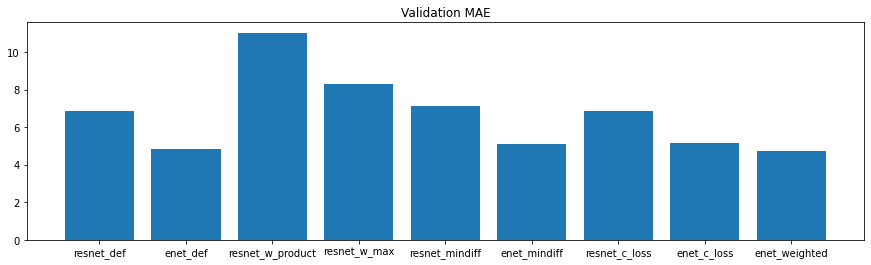

In [ ]:
# plot mae_dict
plt.rcParams["figure.figsize"] = (15, 4)
plt.bar(range(len(mae_dict)), list(mae_dict.values()), align="center")
plt.xticks(range(len(mae_dict)), list(mae_dict.keys()))
plt.title("Validation MAE")
# chage plot size
plt.show()

In [ ]:
age_bias_error = {}
gender_bias_error = {}
ethnicity_bias_error = {}
face_expression_bias_error = {}


Age analysis:
Size group 1 = 305, MAE = 8.473449
Size group 2 = 841, MAE = 5.136657
Size group 3 = 275, MAE = 8.373191
Size group 4 = 61, MAE = 16.155117
---------
Age bias (Ba) =  5.525939305623372
Gender analysis:
Size group female = 716, MAE = 6.626345
Size group male = 766, MAE = 7.112216
---------
Gender bias (Bg) =  0.48587132
Ethnicity Analysis:
Size group asian = 116, MAE = 5.971395
Size group afroamerican = 50, MAE = 6.417099
Size group caucasian = 1316, MAE = 6.974836
---------
Ethnicity bias (Be) =  0.6689608891805013
Face experession Analysis:
Size group happy = 403, MAE = 6.914006
Size group slightlyhappy = 476, MAE = 6.730739
Size group neutral = 492, MAE = 6.764400
Size group other = 111, MAE = 7.875311
---------
Face Expression bias (Bf) =  0.5972205797831217
Age analysis:
Size group 1 = 305, MAE = 8.473449
Size group 2 = 841, MAE = 5.136657
Size group 3 = 275, MAE = 8.373191
Size group 4 = 61, MAE = 16.155117
---------
Age bias (Ba) =  5.525939305623372
Gender analysis

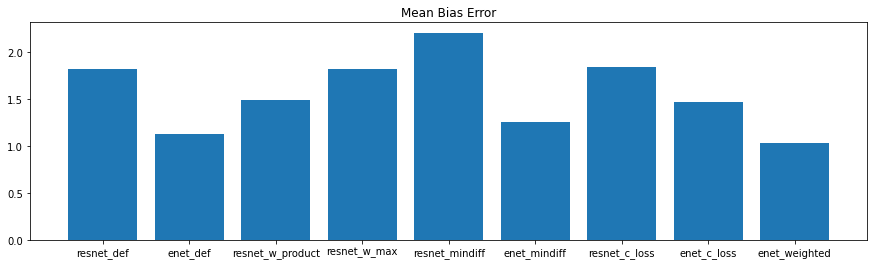

In [ ]:
model_errors = {}
for key in predictions_dict:
    error = []
    # calcuate each bias error and append to list
    error.append(age_bias(predictions_dict[key], Y_valid * 100))
    error.append(gender_bias(predictions_dict[key], Y_valid * 100, M_valid))
    error.append(ethnicity_bias(predictions_dict[key], Y_valid * 100, M_valid))
    error.append(face_expression_bias(predictions_dict[key], Y_valid * 100, M_valid))

    age_bias_error[key] = age_bias(predictions_dict[key], Y_valid * 100)
    gender_bias_error[key] = gender_bias(predictions_dict[key], Y_valid * 100, M_valid)
    ethnicity_bias_error[key] = ethnicity_bias(predictions_dict[key], Y_valid * 100, M_valid)
    face_expression_bias_error[key] = face_expression_bias(
        predictions_dict[key], Y_valid * 100, M_valid
    )

    # print mean error
    model_errors[key] = np.mean(error)

plot_barchart(model_errors, "Mean Bias Error")


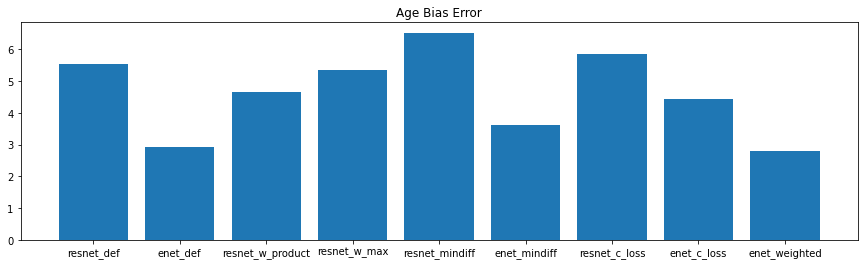

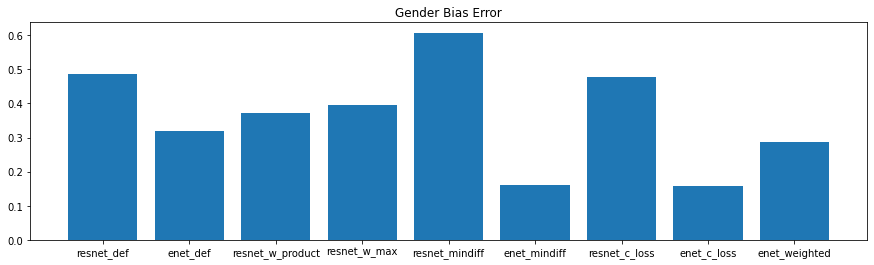

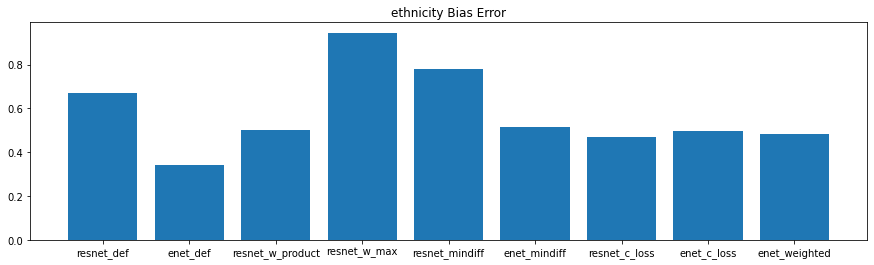

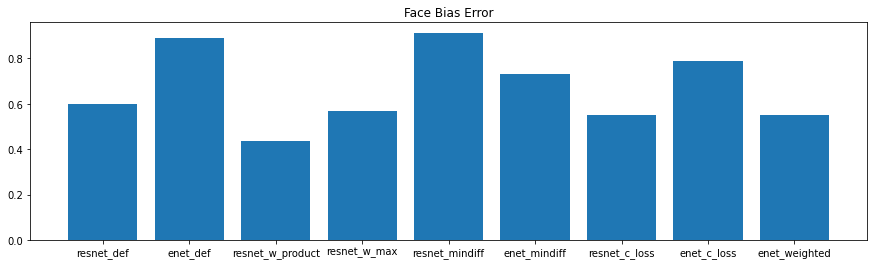

In [ ]:
plot_barchart(age_bias_error, "Age Bias Error")
plot_barchart(gender_bias_error, "Gender Bias Error")
plot_barchart(ethnicity_bias_error, "ethnicity Bias Error")
plot_barchart(face_expression_bias_error, "Face Bias Error")


In [ ]:
bias_errors = {
    "age": age_bias_error,
    "gender": gender_bias_error,
    "face": face_expression_bias_error,
    "ethnicity": ethnicity_bias_error
}

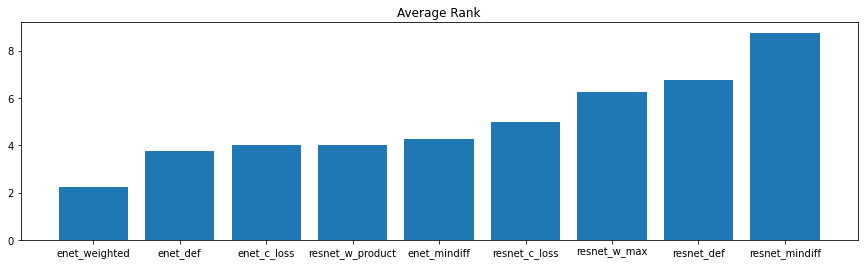

{'enet_weighted': 2.25,
 'enet_def': 3.75,
 'enet_c_loss': 4.0,
 'resnet_w_product': 4.0,
 'enet_mindiff': 4.25,
 'resnet_c_loss': 5.0,
 'resnet_w_max': 6.25,
 'resnet_def': 6.75,
 'resnet_mindiff': 8.75}

In [ ]:
# rank models in each category: age bias, gender bias, ethnicity bias, face expression bias
# then, teka the average of the ranks for each model and plot the results
def rank_models(bias_errors):
    # rank models in each category. Rank 1 is the best model and rank n is the worst model, where n is the number of models
    rank_dict = {}
    for key, errors in bias_errors.items():
        # sort errors
        sorted_errors = {k: v for k, v in sorted(errors.items(), key=lambda item: item[1])}
        # rank models
        rank = 1
        for model, error in sorted_errors.items():
            if model not in rank_dict:
                rank_dict[model] = [rank]
            else:
                rank_dict[model].append(rank)
            rank += 1
    # calculate average rank for each model
    avg_rank = {}
    for model, ranks in rank_dict.items():
        avg_rank[model] = np.mean(ranks)
        
    # sort avg_rank
    avg_rank = {k: v for k, v in sorted(avg_rank.items(), key=lambda item: item[1])}
    # plot average rank
    plot_barchart(avg_rank, "Average Rank")
    return avg_rank

rank_models(bias_errors)

## ✍️ Making predictions on the **Test set** 

In [ ]:
# making predictions on the TEST data
path = paths_dict["enet_weighted"]

saved_model = tf.keras.models.load_model(
    path,
    compile=False
)
predictions_st2_test = saved_model.predict(X_test_enet, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "ages" as the outputs are in the range of [0,1]
predictions_st2_test_final = predictions_st2_test * 100


62/62 [==============================] - 7s 75ms/step


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_test_final)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions.zip predictions.csv

updating: predictions.csv (deflated 54%)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=109b4dea-b824-4d2f-a1ab-8796b4096e61' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>